# 3D EFIT Rail Code in MPI

## Series model using Dieckman, Binggham, et. al. style

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [2]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = False
RailShape = True
figDPI = 600

#Dimmesnsion of simulation space in meters
length1 = 2.5
width1 = 0.1524 # 0.1524
height1 = 0.1524
cycles = 10

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'
runName = 'DoubleRub'

#is the rail supported by 0, 1 or 2 ties
Ties = 0
Flaw = False

#Choose ferquency to be used for excitment
frequency = 49720.0  #brute forced this number to be where simulation frequency 
#                     is 2,000,000, alowing for %10 to equal laser 200k same as actual
#            74574  is 3,000,000 hz running, and sample rate %15 is 200k same as actual, if we need more dense
Signalfrequency = 16300


#Run for 4 Cycles:
runtime = cycles / Signalfrequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
# 3 for plane wave
FFunction = 6
Absorbers = 1

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'RailSide/'
elif FFunction ==3:
    imFolder += 'Cube/'
elif FFunction ==4:
    imFolder += 'Temp/'
elif FFunction == 5:
    imFolder += 'Double3m/'
elif FFunction == 6:   #long rail, two wheel rubs
    imFolder += 'AbsorbTest/'


WheelLoad = 173000 #crane force in Neutons

#CALCULATED PARAMETERS FROM INPUTS

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

In [3]:
#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1) /13)    #grid step
ts = gs/((max(cl1,ct1))*(np.sqrt(3)))*0.93 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +3       #length 
gw1 = int(math.ceil(width1 / gs)) +3      #width
gh1 = int(math.ceil(height1 / gs)) +3       #height

print(gs, ts, gl1, gw1, gh1, Tsteps)

0.004877343816768354 4.5178137402466586e-07 516 35 35 1359


In [4]:
# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

In [5]:
## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round((gh1-3) * relStartHeadThick) + 1
gridStartWeb = round((gw1-3) * relStartWeb)  + 1
gridEndWeb = round((gw1-3) * relEndWeb)  + 1
gridEndFoot = round((gh1-3) * relFoot)  + 1
gridStartHeadWidth = round((gw1-3) * relStartHeadWidth)  + 1
gridEndHeadWidth = round((gw1-3)  * relEndHeadWidth)  + 1



In [6]:
#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matDensity=np.zeros((gl1,gw1,gh1))
matLambda=np.zeros((gl1,gw1,gh1))
matMu=np.zeros((gl1,gw1,gh1))
matBCs=np.zeros((gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))
AbsorbMatrix=np.ones((gl1,gw1,gh1))

matDensity[:,:,:]=rho1
matLambda[:,:,:]=lmbda1
matMu[:,:,:]=mu1
matBCs[:,:,:]=0

#Make the Signal Location grid
if FFunction == 1:
    pnodes = max(int(whlayer / 2),3)
    contactLength = max(int(0.001 / gs),3)  #1 cm contact patch or 3 nodes, whichever is larger
    
    #starting at .25 down, to be between the first 2 ties
    WheelStartPoint = int(0.25 * gl1)
    
    signalLocation[WheelStartPoint:WheelStartPoint+contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
     
    signalLocation[14:20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[13,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[14:20,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5
    
elif FFunction == 3:
    signalLocation[2:4,:,:] = 1


elif FFunction == 4:
    start = 2*int(gh1/5)
    end = 3 * int(gh1/5)
    signalLocation[2:4,start:end,start:end] = 1

elif FFunction == 5:

    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-2] = 1
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-1] = 0.5
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-3] = 0.5
    

elif FFunction == 6:
     
    signalLocation[14:20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[13,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[14:20,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5

    sep = int(1.360/gs)
    
    signalLocation[14+sep:20+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 1

    signalLocation[20+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[13+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[14+sep:20+sep,gridEndHeadWidth-3:gridEndHeadWidth-2,gridStartHead:zmax-2] = 0.5
    

specificWheelLoad = WheelLoad / np.sum(signalLocation)

gl1,npx,nproc 516 516 1
runtime (s), time step size (s), total # of time steps: 0.0006134969325153375 4.5178137402466586e-07 1359
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.004877343816768354 516 35 35 516


In [7]:
if Absorbers >= 1:
    for i in range(12):
        AbsorbMatrix[i,:,:]=i/13
if Absorbers == 2:
    for i in range(12):
        AbsorbMatrix[xmax-i,:,:]=i/13
    
    
if myid == 0:
    print('globs made, line 145')

globs made, line 145


In [8]:
#########
# FUnctions
def JBSU(x,y,z):
    try:
        if (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2):
            pass
        else:
            norm1=(1/gs)*(matLambda[x,y,z]+2*matMu[x,y,z])
            norm2=(1/gs)*(matLambda[x,y,z])

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x+1,y+1,z] == 2):
            pass
        else:
            shearDenomxy=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x+1,y+1,z])
            shearxy=4*(1/gs)*(1/shearDenomxy)
            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z+1] == 2 
            or matBCs[x,y,z-1] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x+1,y,z+1] == 2):
            pass
        else:
            shearDenomxz=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y,z+1])+(1/matMu[x+1,y,z+1])
            shearxz=4*(1/gs)*(1/shearDenomxz)
            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

        if (matBCs[x,y,z] == 2 or matBCs[x,y,z+1] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z+1] == 2):
            pass
        else:
            shearDenomyz=(1/matMu[x,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x,y,z+1])+(1/matMu[x,y+1,z+1])
            shearyz=4*(1/gs)*(1/shearDenomyz)
            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts
    except:
        print('Unrecognized BC stress', matBCs[x,y,z],x,y,z)


In [9]:
# %%
def JBUV(x,y,z):
    
    if matBCs[x,y,z] == 0: 
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    #x at 0
    elif (matBCs[x,y,z] ==2 or matBCs[x,y-1,z]==2 or matBCs[x,y,z-2]==2):
        pass #requires elements out of the direction
    elif matBCs[x+1,y,z] == 2:
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*sxx[x,y,z])

    elif matBCs[x-1,y,z] ==2 :
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*sxx[x+1,y,z])

    else:
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    
    #Vy cases
    if matBCs[x,y,z] == 0: 
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
    #y = 0
    elif (matBCs[x,y,z] ==2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z-1] == 2):
        pass  #requires elements out of the direction
    elif matBCs[x,y+1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*syy[x,y,z])
    elif matBCs[x,y-1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*syy[x,y+1,z])
    else:
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

    #Vz cases
    if matBCs[x,y,z] ==0:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts
    #z at 0
    elif (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z]==2):
        pass
    elif matBCs[x,y,z+1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((-2)*szz[x,y,z])
    elif matBCs[z,y,z-1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((2)*szz[x,y,z+1])
    else:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


In [10]:
def setSimSpaceBC99(matBCs):
    
    matBCs[0,:,:]=99
    matBCs[xmax,:,:]=99
    matBCs[:,0,:]=99
    matBCs[:,ymax,:]=99
    matBCs[:,:,0]=99
    matBCs[:,:,zmax]=99
    
    return matBCs


In [11]:
def setSimSpaceBCs(matBCs):
    #Second Dimmension boundaries /y
    matBCs[:,0,:]=2
    matBCs[:,1,:]=1
    matBCs[:,ymax,:]=2
    matBCs[:,ymax-1,:]=2
    matBCs[:,ymax-2,:]=1

    #Third Dimmension Boundaries /z
    matBCs[:,:,0]=2
    matBCs[:,2:ymax-1,1]=1
    matBCs[:,:,zmax]=2
    matBCs[:,:,zmax-1]=2
    matBCs[:,2:ymax-1,zmax-2]=1
    
    #First Dimmension Boundaries /x
    #   handled different if this is going to be calculated by node
    #   others c does it different, but they split between nodes before calculating
    #   here we calculate the whole set and then parse
    matBCs[0,:,:]=2
    matBCs[1,2:ymax-1,1:zmax-1]=1
    matBCs[xmax,:,:]=2
    matBCs[xmax-1,:,:]=2
    matBCs[xmax-2,1:ymax-1,1:zmax-1]=1
    
    return matBCs
    

In [12]:
def MakeFlaw(matBCs, Type=1):
    #Type 1 is a chunck missing in the middle halfway from the center input to the end
    
    if Type==1:
        MidPoint = int(gl1/2)
        StartTrans = int(gl1/5)*2
        EndTrans = int(gl1/5)*3

        TransToEnd = gl1-EndTrans
        MidTransToEnd = int(TransToEnd/2)+EndTrans
        QuarterTrans = int((EndTrans-StartTrans)/4)

        StartFlawX = MidTransToEnd - QuarterTrans
        EndFlawX = MidTransToEnd + QuarterTrans

        StartFlawY = MidPoint - QuarterTrans
        EndFlawY = MidPoint + QuarterTrans

        VertFlaw = int(gh1/8)
        VertStart = zmax - VertFlaw

        #main hole
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart:] = 2

        #edges
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart-1] = 1
        matBCs[StartFlawX-1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[EndFlawX+1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,StartFlawY-1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,EndFlawY+1,VertStart:zmax-2]=1
    
    return matBCs
    

In [13]:
def setRailBCs(matBCs):
    #top of foot
    matBCs[:,1:gridStartWeb,gridEndFoot]=1
    matBCs[:,gridEndWeb:ymax-1,gridEndFoot]=1

    #Sides Web
    matBCs[:,gridStartWeb,gridEndFoot:gridStartHead] = 1
    matBCs[:,gridEndWeb,gridEndFoot:gridStartHead] =1

    #bottom Head
    matBCs[:,gridStartHeadWidth:gridStartWeb+1,gridStartHead] = 1
    matBCs[:,gridEndWeb:gridEndHeadWidth,gridStartHead] = 1

    #Sides HEad
    matBCs[:,gridStartHeadWidth,gridStartHead:zmax-1] = 1
    matBCs[:,gridEndHeadWidth,gridStartHead:zmax-1] = 1

    #air beside Web
    matBCs[:,1:gridStartWeb,gridEndFoot+1:gridStartHead] = 2
    matBCs[:,gridEndWeb+1:ymax,gridEndFoot+1:gridStartHead] = 2

    #air beside head
    matBCs[:,1:gridStartHeadWidth,gridStartHead:zmax] = 2
    matBCs[:,gridEndHeadWidth+1:ymax,gridStartHead:zmax] = 2

    
    return matBCs

In [14]:
#matBCs = setSimSpaceBC99(matBCs)
matBCs = setSimSpaceBCs(matBCs)
    

In [15]:
if RailShape:
    #matDensity,matLambda,matMu = setAirCut(matDensity,matLambda,matMu)
    matBCs = setRailBCs(matBCs)
    #matBCs = addTies(matBCs,Ties)

#Add Flaw
#    136 x 136 x15
if Flaw:
    matBCs = MakeFlaw(matBCs)

In [16]:
np.savetxt("BCs.csv",matBCs[9,:,:].T,delimiter=",")

air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


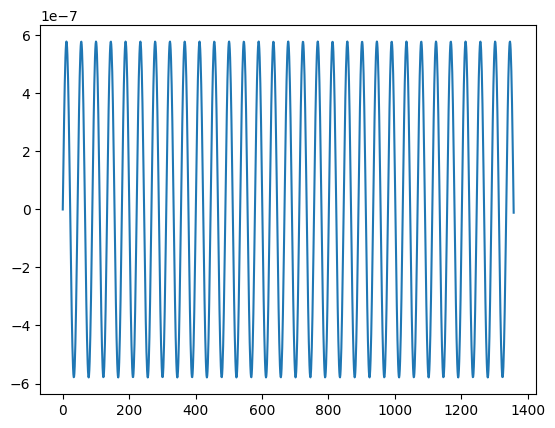

In [17]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)
#sinInputSignal-=0.0000001
#sinInputSignal[int(1/12*Tsteps):]=0

fig = plt.figure()
plt.plot(sinInputSignal)
plt.show()

In [18]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

In [19]:

#record the signal at a specified location
### ADD map function for this
#SAME AS INPUTZ?

#manually setting x for long where wave may not propaagate full lengthh in time

## All signals at 4 nodes from end
FromEnd = 50
# Top of rail
FSignalLocX= gl1-FromEnd
FSignalLocY=int(gw1/2)
FSignalLocZ=gh1-4

## End halfway up head
BSignalLocX=gl1-FromEnd
BSignalLocY=int(gw1/2)
BSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## left of head
USignalLocX=gl1-FromEnd
USignalLocY=gridStartHeadWidth+1
USignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of head
DSignalLocX=gl1-FromEnd
DSignalLocY=gridEndHeadWidth-1
DSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of web
RSignalLocX=gl1-FromEnd
RSignalLocY=gridStartWeb+1
RSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## Left of Web
LSignalLocX=gl1-FromEnd
LSignalLocY=gridEndWeb-1
LSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## End of Web
MSignalLocX=gl1-FromEnd
MSignalLocY=int(gw1/2)
MSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)


#signal locations going to be a quarter of the way in the middle from the 
# Front, Back, Up side, Down side, Right, Left, and Middle Middle Middle
FSignal=np.zeros((Tsteps,3))
BSignal=np.zeros((Tsteps,3))
USignal=np.zeros((Tsteps,3))
DSignal=np.zeros((Tsteps,3))
RSignal=np.zeros((Tsteps,3))
LSignal=np.zeros((Tsteps,3))
MSignal=np.zeros((Tsteps,3))

In [20]:
signalloc = np.zeros((npx,gw1,gh1))
signalloc=signalLocation[:,:,:]

stime = time.time()

In [21]:
# asdfasdf
MidMatrixX = np.zeros((gl1,Tsteps))
MidMatrixY = np.zeros((gl1,Tsteps))
MidMatrixZ = np.zeros((gl1,Tsteps))

Movements = np.zeros((gl1,gw1,gh1,Tsteps))
DisX = np.zeros((gl1,gw1,gh1))
DisY = np.zeros((gl1,gw1,gh1))
DisZ = np.zeros((gl1,gw1,gh1))


In [22]:
writeFile = open(imFolder + 'LaserPoints.csv','a')
writeFile.write('Time,topX, topY, topZ, endX, endY, endZ, rHeadX, rHeadY, rHeadZ, lHeadX, lHeadY, lHeadZ, rWebX, rWebY, rWebZ, lWebX, lWebY, lWebZ')
AnimationData =  open(imFolder + 'Anima.csv','a')
AnimationData.write("time,x,y,z,Energy\n")

18

In [ ]:
for t in range(Tsteps):
     
    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
        #print(np.sum(vz))
    
    if FFunction == 3:
        vx += signalloc * sinInputSignal[t]

    if FFunction == 4 or  FFunction == 5 or  FFunction == 6:
        vz += signalloc * sinInputSignal[t]

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBSU(x,y,z)
                if matBCs[x,y,z]==1:
                    AnimationData.write(str(t)+","+str(x)+","+str(y)+","+str(z)+","
                                        +str(np.sqrt(vx[x,y,z]**2+vy[x,y,z]**2+vz[x,y,z]**2))
                                        +"\n")
    vx *= AbsorbMatrix
    #vy *= AbsorbMatrix
    #vz *= AbsorbMatrix
    
    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBUV(x,y,z)

    MidMatrixX[:,t] = vx[:,MSignalLocY,MSignalLocZ]
    MidMatrixY[:,t] = vy[:,MSignalLocY,MSignalLocZ]
    MidMatrixZ[:,t] = vz[:,MSignalLocY,MSignalLocZ]
    
    vxg=vx #[1:npx+1,:,:]        
    vyg=vy#[1:npx+1,:,:]        
    vzg=vz#[1:npx+1,:,:]        

    
    if (myid == 0 ) :
        USignal[t]=[vxg[USignalLocX,USignalLocY,USignalLocZ],vyg[USignalLocX,USignalLocY,USignalLocZ],vzg[USignalLocX,USignalLocY,USignalLocZ]]
        DSignal[t]=[vxg[DSignalLocX,DSignalLocY,DSignalLocZ],vyg[DSignalLocX,DSignalLocY,DSignalLocZ],vzg[DSignalLocX,DSignalLocY,DSignalLocZ]]
        RSignal[t]=[vxg[RSignalLocX,RSignalLocY,RSignalLocZ],vyg[RSignalLocX,RSignalLocY,RSignalLocZ],vzg[RSignalLocX,RSignalLocY,RSignalLocZ]]
        LSignal[t]=[vxg[LSignalLocX,LSignalLocY,LSignalLocZ],vyg[LSignalLocX,LSignalLocY,LSignalLocZ],vzg[LSignalLocX,LSignalLocY,LSignalLocZ]]
        MSignal[t]=[vxg[MSignalLocX,MSignalLocY,MSignalLocZ],vyg[MSignalLocX,MSignalLocY,MSignalLocZ],vzg[MSignalLocX,MSignalLocY,MSignalLocZ]]
        FSignal[t]=[vxg[FSignalLocX,FSignalLocY,FSignalLocZ],vyg[FSignalLocX,FSignalLocY,FSignalLocZ],vzg[FSignalLocX,FSignalLocY,FSignalLocZ]]
        BSignal[t]=[vxg[BSignalLocX,BSignalLocY,BSignalLocZ],vyg[BSignalLocX,BSignalLocY,BSignalLocZ],vzg[BSignalLocX,BSignalLocY,BSignalLocZ]]
        
        DisX += vx[:,:,:] * ts
        DisY += vy[:,:,:] * ts
        DisZ += vz[:,:,:] * ts
        Movements[:,:,:,t] = np.sqrt(DisX**2 + DisY**2 + DisZ**2)
        writeFile.write(str(t)+','
                 +str(FSignal[-1][0])+','+str(FSignal[-1][1])+','+str(FSignal[-1][2])+','
                 +str(BSignal[-1][0])+','+str(BSignal[-1][1])+','+str(BSignal[-1][2])+','
                 +str(USignal[-1][0])+','+str(USignal[-1][1])+','+str(USignal[-1][2])+','
                 +str(DSignal[-1][0])+','+str(DSignal[-1][1])+','+str(DSignal[-1][2])+','
                 +str(RSignal[-1][0])+','+str(RSignal[-1][1])+','+str(RSignal[-1][2])+','
                 +str(LSignal[-1][0])+','+str(LSignal[-1][1])+','+str(LSignal[-1][2])+','
                 +str(MSignal[-1][0])+','+str(MSignal[-1][1])+','+str(MSignal[-1][2])+'\n'
                )
        if t%5==0:
        
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vyMidHeightShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vyVertShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)    
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[int(gl1/2),:,:]), cmap='seismic')
            plt.savefig(imFolder + 'Head/vyMidLenShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane25/vy25Shear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(3*gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane75/vy75Shear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[:,:,zmax-1,t]), cmap='seismic')
            plt.savefig(imFolder+'TopSurface/TopSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,ymax,:,t]), cmap='seismic')
            plt.savefig(imFolder+'RightSurface/RightSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,0,:,t]), cmap='seismic')
            plt.savefig(imFolder+'LeftSurface/LeftSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            

    # Collect vx, sxx checksum contributions for printing
    vxt=vx[1:npx+1,:,:]
    sxxt=sxx[1:npx+1,:,:]

    #ckvs=np.array(0.0,'d')
    #ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxg))
    cks=np.sum(np.absolute(sxx))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'check vx, sxx:',ckv,cks, int(((time.time()-stime)/60.0)*100)/100)
    sys.stdout.flush()

0 / 1358 check vx, sxx: 0.0 0.0 0.22
1 / 1358 check vx, sxx: 1.879097376798e-07 21.812847576653052 0.39
2 / 1358 check vx, sxx: 8.802110889230041e-07 79.41737338262823 0.57
3 / 1358 check vx, sxx: 2.45451708795538e-06 176.32360050332824 0.74
4 / 1358 check vx, sxx: 5.330481328383205e-06 311.1253915529788 0.91
5 / 1358 check vx, sxx: 9.967118091964994e-06 488.3414172281843 1.1
6 / 1358 check vx, sxx: 1.6834594590294147e-05 743.8128236034061 1.28
7 / 1358 check vx, sxx: 2.6365475006946316e-05 1092.0054385336073 1.45
8 / 1358 check vx, sxx: 3.890795882504801e-05 1570.4693594086648 1.63
9 / 1358 check vx, sxx: 5.463498729135764e-05 2190.679952389288 1.8
10 / 1358 check vx, sxx: 7.355349356595539e-05 2961.118044239345 1.99
11 / 1358 check vx, sxx: 9.555048719757795e-05 3877.563645319506 2.17
12 / 1358 check vx, sxx: 0.00012045102756790015 4916.550313555555 2.34
13 / 1358 check vx, sxx: 0.00014796821317957068 6122.790494250154 2.51
14 / 1358 check vx, sxx: 0.00017776578396264228 7467.9763830

117 / 1358 check vx, sxx: 0.006060866248943761 228717.70260920658 20.98
118 / 1358 check vx, sxx: 0.006146727977467037 231325.04063001028 21.16
119 / 1358 check vx, sxx: 0.006223944188262667 234064.38451568966 21.33
120 / 1358 check vx, sxx: 0.006292920773576127 236742.4293934143 21.53
121 / 1358 check vx, sxx: 0.006348090412158364 239429.70964353482 21.7
122 / 1358 check vx, sxx: 0.006391459286595127 242146.60116301625 21.88
123 / 1358 check vx, sxx: 0.006420473364897635 244641.370546257 22.05
124 / 1358 check vx, sxx: 0.006438703657425358 246771.97680028202 22.22
125 / 1358 check vx, sxx: 0.006454963082941363 248885.14133949162 22.41
126 / 1358 check vx, sxx: 0.006468459167605723 250666.7260337873 22.59
127 / 1358 check vx, sxx: 0.0064885288272394865 252204.66596242593 22.76
128 / 1358 check vx, sxx: 0.006516085696100501 253637.10652353332 22.94
129 / 1358 check vx, sxx: 0.0065518771244704194 254695.42166772345 23.11
130 / 1358 check vx, sxx: 0.006598245088759769 255791.60745838375 2

234 / 1358 check vx, sxx: 8.33543992899133 255789292.32221454 41.86
235 / 1358 check vx, sxx: 9.59745557466172 294513028.60608107 42.05
236 / 1358 check vx, sxx: 11.050847660684665 339109083.1195005 42.22
237 / 1358 check vx, sxx: 12.724645930919191 390467913.07453775 42.4
238 / 1358 check vx, sxx: 14.65227411141215 449615064.89615047 42.57
239 / 1358 check vx, sxx: 16.872227173850856 517731298.12422085 42.75
240 / 1358 check vx, sxx: 19.42883387852614 596176993.3664547 42.94
241 / 1358 check vx, sxx: 22.373132055954983 686518085.1888772 43.12
242 / 1358 check vx, sxx: 25.763894326692114 790558085.1293962 43.3
243 / 1358 check vx, sxx: 29.668810395898195 910374395.8239579 43.47
244 / 1358 check vx, sxx: 34.16581732178483 1048359432.3819754 43.65
245 / 1358 check vx, sxx: 39.34469322444006 1207267282.0434895 43.84
246 / 1358 check vx, sxx: 45.30881592422255 1390270072.9305792 44.01
247 / 1358 check vx, sxx: 52.17724853562286 1601021439.7771134 44.19
248 / 1358 check vx, sxx: 60.08709256

354 / 1358 check vx, sxx: 188783097.8972555 5792852329173952.0 63.37
355 / 1358 check vx, sxx: 217392882.94154838 6670751308723024.0 63.56
356 / 1358 check vx, sxx: 250338355.12492514 7681692183442236.0 63.74
357 / 1358 check vx, sxx: 288276557.7144748 8845836550652026.0 63.92
358 / 1358 check vx, sxx: 331964102.81718034 1.0186401314598658e+16 64.09
359 / 1358 check vx, sxx: 382272259.9138881 1.1730121684145424e+16 64.27
360 / 1358 check vx, sxx: 440204330.8626401 1.3507784331747824e+16 64.46
361 / 1358 check vx, sxx: 506915657.8519551 1.555484134562191e+16 64.64
362 / 1358 check vx, sxx: 583736663.2881702 1.7912117218109956e+16 64.81
363 / 1358 check vx, sxx: 672199381.0605958 2.0626622968483212e+16 64.99
364 / 1358 check vx, sxx: 774068008.2490892 2.375249363477171e+16 65.17
365 / 1358 check vx, sxx: 891374086.5097396 2.7352067829294636e+16 65.36
366 / 1358 check vx, sxx: 1026457014.6935549 3.1497130885419332e+16 65.53
367 / 1358 check vx, sxx: 1182010700.5617898 3.62703463852246e+16

467 / 1358 check vx, sxx: 1585921088458984.8 4.866485671736051e+22 83.61
468 / 1358 check vx, sxx: 1826230667306299.5 5.603888979740705e+22 83.78
469 / 1358 check vx, sxx: 2102953448357522.5 6.453028252511031e+22 83.96
470 / 1358 check vx, sxx: 2421606966976051.0 7.430834362392256e+22 84.15
471 / 1358 check vx, sxx: 2788544804193723.5 8.556803636132062e+22 84.33
472 / 1358 check vx, sxx: 3211083268341313.5 9.853386584848995e+22 84.5
473 / 1358 check vx, sxx: 3697647272035625.5 1.1346435536081285e+23 84.67
474 / 1358 check vx, sxx: 4257938313081241.0 1.3065720092998861e+23 84.85
475 / 1358 check vx, sxx: 4903127908560571.0 1.5045520698223303e+23 85.04
476 / 1358 check vx, sxx: 5646080338880169.0 1.7325312136977223e+23 85.22
477 / 1358 check vx, sxx: 6501609142932913.0 1.9950550607525107e+23 85.39
478 / 1358 check vx, sxx: 7486772478476217.0 2.297358005182611e+23 85.57
479 / 1358 check vx, sxx: 8621213236733366.0 2.6454675817167427e+23 85.75
480 / 1358 check vx, sxx: 9927550692548264.0 3

575 / 1358 check vx, sxx: 6.573071348303988e+21 2.016987191490749e+29 102.91
576 / 1358 check vx, sxx: 7.569038758631836e+21 2.322605909256255e+29 103.09
577 / 1358 check vx, sxx: 8.715917387845382e+21 2.6745326641649907e+29 103.27
578 / 1358 check vx, sxx: 1.003657362474898e+22 3.0797841488372536e+29 103.44
579 / 1358 check vx, sxx: 1.1557338619562034e+22 3.5464402393791566e+29 103.62
580 / 1358 check vx, sxx: 1.3308533271235196e+22 4.083805090996639e+29 103.81
581 / 1358 check vx, sxx: 1.532507276180997e+22 4.702592643113983e+29 103.99
582 / 1358 check vx, sxx: 1.76471626909298e+22 5.415140232568086e+29 104.16
583 / 1358 check vx, sxx: 2.032110068991835e+22 6.235654573863563e+29 104.34
584 / 1358 check vx, sxx: 2.3400199497872774e+22 7.180495010802301e+29 104.51
585 / 1358 check vx, sxx: 2.694584990390745e+22 8.268499686911026e+29 104.7
586 / 1358 check vx, sxx: 3.1028744748308617e+22 9.521361137797434e+29 104.88
587 / 1358 check vx, sxx: 3.573028838652301e+22 1.096405879393066e+30 1

681 / 1358 check vx, sxx: 2.054077761042403e+28 6.3030663183215816e+35 121.92
682 / 1358 check vx, sxx: 2.365314500179447e+28 7.258115768277606e+35 122.1
683 / 1358 check vx, sxx: 2.7237102564529403e+28 8.357875621267335e+35 122.27
684 / 1358 check vx, sxx: 3.136410627467397e+28 9.624272592138214e+35 122.45
685 / 1358 check vx, sxx: 3.611643921197822e+28 1.108255576051612e+36 122.64
686 / 1358 check vx, sxx: 4.158885209669002e+28 1.2761799979829362e+36 122.81
687 / 1358 check vx, sxx: 4.7890452402578065e+28 1.4695485563511587e+36 122.99
688 / 1358 check vx, sxx: 5.514687971076856e+28 1.6922165805997937e+36 123.16
689 / 1358 check vx, sxx: 6.350281067596383e+28 1.9486235647352775e+36 123.34
690 / 1358 check vx, sxx: 7.312484354832439e+28 2.2438816806939422e+36 123.53
691 / 1358 check vx, sxx: 8.420481976176496e+28 2.5838777033666933e+36 123.71
692 / 1358 check vx, sxx: 9.696364881351447e+28 2.9753903794325933e+36 123.88
693 / 1358 check vx, sxx: 1.116557126942607e+29 3.426225580066592e+

787 / 1358 check vx, sxx: 6.418666874069253e+34 1.969608358558697e+42 140.83
788 / 1358 check vx, sxx: 7.391230835845908e+34 2.2680457369494106e+42 141.01
789 / 1358 check vx, sxx: 8.511158827413884e+34 2.6117026963426272e+42 141.18
790 / 1358 check vx, sxx: 9.800779618129734e+34 3.007430960314971e+42 141.37
791 / 1358 check vx, sxx: 1.1285805258354298e+35 3.4631204335406515e+42 141.55
792 / 1358 check vx, sxx: 1.2995843718093749e+35 3.987856508189432e+42 141.73
793 / 1358 check vx, sxx: 1.4964989201236661e+35 4.5921012055708633e+42 141.9
794 / 1358 check vx, sxx: 1.723250190488236e+35 5.2879017645685754e+42 142.08
795 / 1358 check vx, sxx: 1.984359077658329e+35 6.089130835633694e+42 142.27
796 / 1358 check vx, sxx: 2.2850314875862974e+35 7.011763069247882e+42 142.44
797 / 1358 check vx, sxx: 2.6312621311065385e+35 8.074193613387668e+42 142.62
798 / 1358 check vx, sxx: 3.029954044558581e+35 9.297604870089885e+42 142.79
799 / 1358 check vx, sxx: 3.4890562203119775e+35 1.0706388823392373

893 / 1358 check vx, sxx: 2.005709825393119e+41 6.15464707842376e+48 159.91
894 / 1358 check vx, sxx: 2.3096172375604397e+41 7.08720613763093e+48 160.09
895 / 1358 check vx, sxx: 2.659573042689551e+41 8.161067594634336e+48 160.28
896 / 1358 check vx, sxx: 3.0625545450174763e+41 9.39764174751444e+48 160.45
897 / 1358 check vx, sxx: 3.526596257749421e+41 1.0821583006746019e+49 160.63
898 / 1358 check vx, sxx: 4.060950092546877e+41 1.2461281446745388e+49 160.81
899 / 1358 check vx, sxx: 4.6762698211063865e+41 1.434942883785867e+49 160.98
900 / 1358 check vx, sxx: 5.3848234865633116e+41 1.652367044415089e+49 161.18
901 / 1358 check vx, sxx: 6.20073799970938e+41 1.9027355582326052e+49 161.35
902 / 1358 check vx, sxx: 7.140280796702986e+41 2.1910401906175255e+49 161.53
903 / 1358 check vx, sxx: 8.22218417387114e+41 2.5230290648372123e+49 161.71
904 / 1358 check vx, sxx: 9.468018766083636e+41 2.90532126624193e+49 161.88
905 / 1358 check vx, sxx: 1.0902623614988641e+42 3.3455388114153676e+49 1

999 / 1358 check vx, sxx: 6.267441639808406e+47 1.923203999981045e+55 178.89
1000 / 1358 check vx, sxx: 7.217091384702669e+47 2.2146100143065077e+55 179.08
1001 / 1358 check vx, sxx: 8.31063311737499e+47 2.550170192715758e+55 179.26
1002 / 1358 check vx, sxx: 9.569869512141897e+47 2.9365748233494687e+55 179.43
1003 / 1358 check vx, sxx: 1.1019906808819222e+48 3.381527914260084e+55 179.61
1004 / 1358 check vx, sxx: 1.2689655372645661e+48 3.893900793381836e+55 179.78
1005 / 1358 check vx, sxx: 1.4612406099603312e+48 4.483908982139229e+55 179.97
1006 / 1358 check vx, sxx: 1.682649415931419e+48 5.163315869141636e+55 180.15
1007 / 1358 check vx, sxx: 1.937606330899939e+48 5.94566724474287e+55 180.32
1008 / 1358 check vx, sxx: 2.2311946017140312e+48 6.846561372538338e+55 180.5
1009 / 1358 check vx, sxx: 2.569267694445697e+48 7.883959982396137e+55 180.67
1010 / 1358 check vx, sxx: 2.958565998865237e+48 9.078546385498473e+55 180.86
1011 / 1358 check vx, sxx: 3.4068512161075925e+48 1.0454137851

In [ ]:
writeFile.close()
AnimationData.close()

In [ ]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

Times = np.linspace(0, len(MSignal), num=len(MSignal)+1)
Times *= ts

for i in range(len(MSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+MSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+MSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+MSignal[i][2] * ts)

plt.clf()
plt.title('Middle Node')
plt.plot(Times,vxDisplacement,label='x')
plt.plot(Times,vyDisplacement,label='y')
plt.plot(Times,vzDisplacement,label='z')
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid.png')
#plt.show()

In [ ]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(FSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+FSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+FSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+FSignal[i][2] * ts)

plt.clf()
plt.title('Middle XY Plane Quarter into Rod')
plt.plot(Times,vxDisplacement,label='x', linewidth=2)
plt.plot(Times,vyDisplacement,label='y', linewidth=4)
plt.plot(Times,vzDisplacement,label='z', linewidth=2)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceFront.png')
plt.show()

In [ ]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(BSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+BSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+BSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+BSignal[i][2] * ts)

plt.clf()
plt.title('Back Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceBack.png')

In [ ]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(USignal)):
    vxDisplacement.append(vxDisplacement[i-1]+USignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+USignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+USignal[i][2] * ts)

plt.clf()
plt.title('Up Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceUp.png')

In [ ]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(DSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+DSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+DSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+DSignal[i][2] * ts)

plt.clf()
plt.title('Down Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceDown.png')

In [ ]:
MidDisplaceX = np.zeros(np.shape(MidMatrixX))
MidDisplaceY = np.zeros(np.shape(MidMatrixY))
MidDisplaceZ = np.zeros(np.shape(MidMatrixZ))


In [ ]:
for i in range(np.shape(MidMatrixX)[0]):
    for j in range(np.shape(MidMatrixX)[1]):
        if j == 0:
            MidDisplaceX[i,j]=MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidMatrixZ[i,j]*ts
        else:
            MidDisplaceX[i,j]=MidDisplaceX[i,j-1]+MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidDisplaceY[i,j-1]+MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidDisplaceZ[i,j-1]+MidMatrixZ[i,j]*ts
            

In [ ]:
pts = 8
rng = int(gl1/pts)-1

fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidMatrixX[i*rng,:],label=str(i*rng))
plt.title('Velocity')
plt.legend()
plt.savefig(imFolder+runName+'MidVelocities.png')
plt.show()

In [ ]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceX[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsX.png')
plt.show()

In [ ]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceY[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsY.png')
plt.show()

In [ ]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceZ[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsZ.png')
plt.show()

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=19

In [ ]:
def EnergyFig(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, figH):
    
    fig = plt.figure(figsize=(6,figH), dpi=300)
    
    Image = Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,t].T
    
    x,y,z = np.shape(Image)
    if x ==1:
        I2 = np.squeeze(Image, axis=(0,))
    if y ==1:
        I2 = np.squeeze(Image, axis=(1,))
    if z ==1:
        I2 = np.squeeze(Image, axis=(2,))
    
    plt.contourf(I2, v, cmap=plt.cm.jet)
    plt.savefig(imFolder+Folder+'/Energy'+str(t).zfill(5)+'.png')
    plt.close(fig)

In [ ]:
def AnimationBook(xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder):

    if xStart - xEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (zEnd-zStart)
        xEnd+=1
    elif yStart - yEnd == 0.0:
        figH = 6 * (zEnd - zStart) / (xEnd-xStart)
        yEnd+=1
    elif zStart - zEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (xEnd-xStart)
        zEnd+=1
    else:
        figH = 0

    if figH==0:
        print("Error, no Dimmension is a plane",yStart-yEnd)
    else:
        EMin = np.min(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        EMax = np.max(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

        temp = Parallel(n_jobs=num_jobs)(delayed(EnergyFig)(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH) for t in range(Tsteps))


In [ ]:
plt.close('all')
AnimationBook(0,xmax,gridEndWeb-1,gridEndWeb-1,gridEndFoot,gridStartHead,"WebEnd")
plt.close('all')
AnimationBook(0,xmax,gridEndHeadWidth-1,gridEndHeadWidth-1,gridStartHead,zmax,"HeadEnd")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridEndHeadWidth,zmax-3,zmax-3,"TopSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridStartHeadWidth,gridStartHead,zmax,"LeftSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartWeb,gridStartWeb,gridEndFoot,gridStartHead,"RightSurface")
plt.close('all')


In [ ]:
import glob
import os as os

In [ ]:
import keras.utils as image

In [ ]:
Views = ['Mid', 'Vert','Head','zplane25','zplane75','TopSurface','Energy','LeftSurface','RightSurface','TopEnergy','HeadEnd','WebEnd']


In [ ]:
imFolder

In [ ]:
for View in Views:
    imfolder = imFolder + View+'/'
    files = glob.glob(os.path.join(imfolder, '*.png'))
    print(View, len(files))
    files.sort()
    images = []

    for file in files:
        images.append(image.load_img(file))
    try:
        images[0].save(imFolder + 'Testing'+View+'.gif',
           save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
    except:
        pass

In [ ]:
SaveData = np.concatenate((FSignal,BSignal), axis = 1)

In [ ]:
SaveData = np.concatenate((SaveData,USignal), axis =1)
SaveData = np.concatenate((SaveData,DSignal), axis =1)
SaveData = np.concatenate((SaveData,RSignal), axis =1)
SaveData = np.concatenate((SaveData,LSignal), axis =1)
SaveData = np.concatenate((SaveData,MSignal), axis =1)



In [ ]:
np.shape(SaveData)

In [ ]:
SaveData = np.asarray(SaveData).reshape(2717,21)

In [ ]:
np.savetxt(runName+'LaserPoints2.csv',SaveData,delimiter=", ")

In [ ]:
import CoreFunctions as cf